# 成交量指标策略
*市场短期是投票机，长期是称重机*

## 目录
1. 什么是成交量？
2. 如何计算成交量指标？
3. 如何用图形展示成交量？
4. 如何用成交量指标来编写策略？

## 什么是成交量？

成交量有三种可能，分别是量增、量减、量平。 

价格也有三种可能，分别是上涨、下跌、横盘。

量价理论表明价涨量增是上涨趋势的确认，反之价跌量增是下跌趋势的确认。

## 如何计算成交量指标？
---
### 1. ADV-平均成交量
$MA(volume,20)$

---

### 2. OBV
OBV属于市场的领先指标，计算方法是如果当天价格高于前一天的价格，当天成交量就用加的，反之就用减的来计算出OBV指标，这样有助于分析成交量与价格的关系。

---

### 3. A/D
A/D 指标在OBV的基础上对价格的波幅进行了计算，真实波幅越大，指标中的成交量占比越大。

$\frac{A}{D}=\frac{Close-Open}{High-Low}*Volume$

---

### 4. WVAP
按成交量来衡量价格的权重，成交量越大价格权重越大。

$sum(close * volume, 20)/sum(volume, 20)$

## 如何用图形展示成交量？

In [4]:
from jaqs_fxdayu.data import DataView
from jaqs_fxdayu.data import RemoteDataService
import numpy as np
from talib import abstract
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [5]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df

close = change_index(dv.get_ts('close_adj').loc[20170105:])
volume = change_index(dv.get_ts('volume').loc[20170105:])

<BarContainer object of 242 artists>

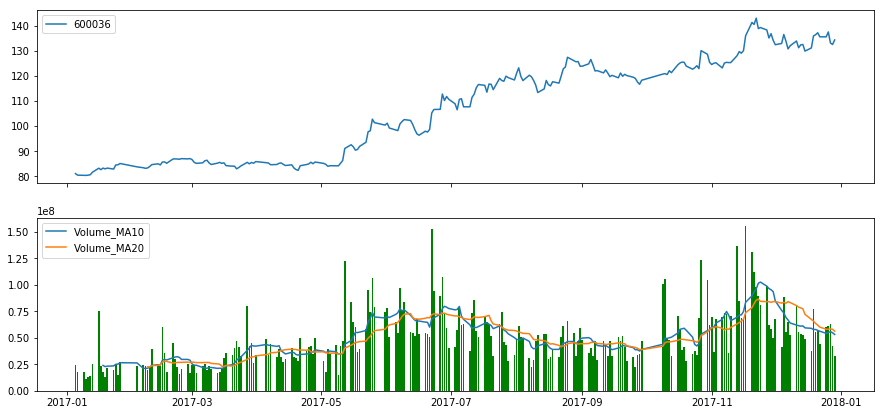

In [6]:
adv10 = ta.abstract.MA(volume, 10, price='600036.SH')
adv20 = ta.abstract.MA(volume, 20, price='600036.SH')

fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(15,7))
ax.plot(close['600036.SH'], label='600036')
ax.legend(loc='upper left')
ax1.bar(volume.index, volume['600036.SH'],color='g')
ax1.plot(adv10, label='Volume_MA10')
ax1.plot(adv20, label='Volume_MA20')
plt.legend(loc='upper left')
plt.show()

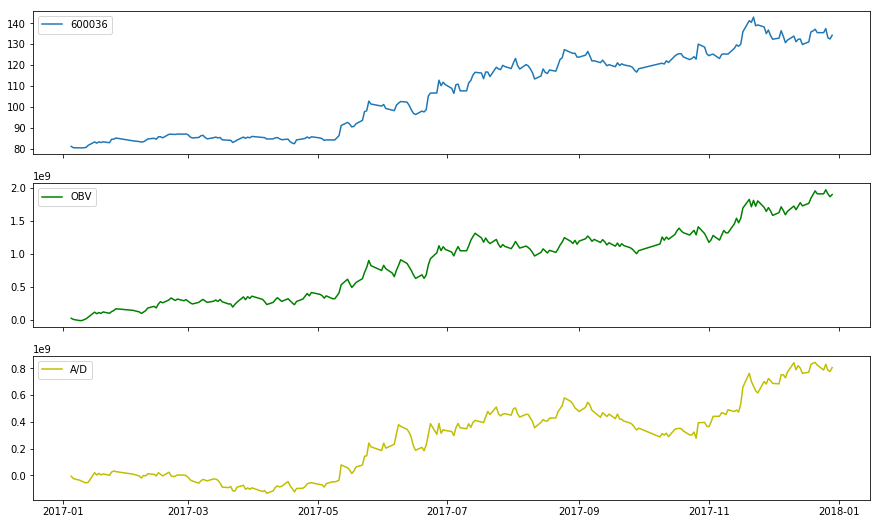

In [7]:
#OBV & A/D
Close = close['600036.SH'].values
Volume = volume['600036.SH'].values
Low = change_index(dv.get_ts('low_adj').loc[20170105:])['600036.SH'].values
High = change_index(dv.get_ts('high_adj').loc[20170105:])['600036.SH'].values


OBV = pd.Series(ta.OBV(Close, Volume), index=close.index)
AD = pd.Series(ta.AD(High, Low, Close, Volume), index=close.index)

fig, (ax, ax1,ax2) = plt.subplots(3, 1, sharex=True, figsize=(15,9))
ax.plot(close['600036.SH'], label='600036')
ax.legend(loc='upper left')
ax1.plot(OBV,'g', label='OBV')
ax1.legend(loc='upper left')
ax2.plot(AD, 'y', label='A/D')
ax2.legend(loc='upper left')
plt.show()

<Figure size 1080x504 with 0 Axes>

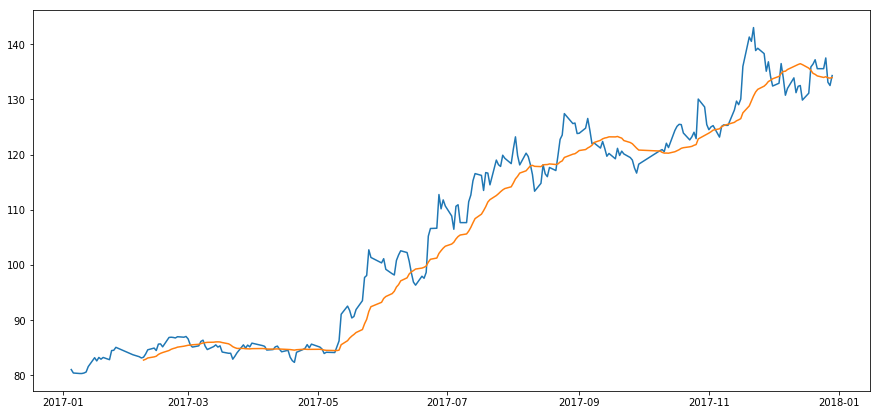

In [8]:
def ts_sum(ts, window=20):
    return ts.rolling(window).sum()

VWAP = ts_sum(pd.Series(Volume,index=volume.index)*close['600036.SH'])/ts_sum(pd.Series(Volume,index=volume.index))

plt.figure(figsize=(15,7))
plt.plot(close['600036.SH'])
plt.plot(VWAP)
plt.show()

## 如何用成交量指标来编写策略？
### VWAP策略
买入：

close>VWAP

卖出：

close<VWAP


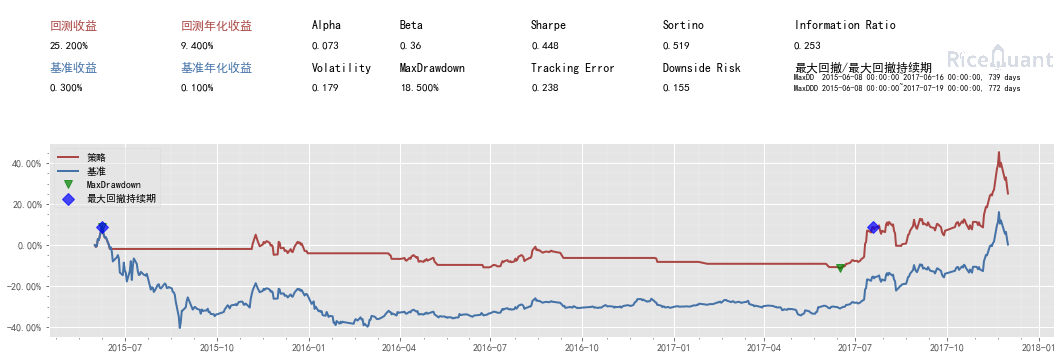

{'sys_analyser': {'summary': {'strategy_name': 'strategy',
   'start_date': '2015-06-01',
   'end_date': '2017-12-01',
   'strategy_file': 'strategy.py',
   'run_type': 'BACKTEST',
   'benchmark': '000001.XSHE',
   'STOCK': 1000000.0,
   'alpha': 0.073,
   'beta': 0.36,
   'sharpe': 0.448,
   'information_ratio': 0.253,
   'downside_risk': 0.155,
   'tracking_error': 0.238,
   'sortino': 0.519,
   'volatility': 0.179,
   'max_drawdown': 0.185,
   'total_value': 1251912.142,
   'cash': 12.142,
   'total_returns': 0.252,
   'annualized_returns': 0.094,
   'unit_net_value': 1.252,
   'units': 1000000.0,
   'benchmark_total_returns': 0.003,
   'benchmark_annualized_returns': 0.001},
  'trades':                      commission         exec_id  last_price  last_quantity  \
  datetime                                                                     
  2015-06-01 15:00:00    798.8160  15337139130000       15.90          62800   
  2015-06-16 15:00:00    785.7536  15337139130001       15.64 

In [9]:
#VWAP

import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.PERIOD = 60


def handle_bar(context, bar_dict):

    price = history_bars(context.s1, context.PERIOD+1, '1d', 'close')
    volume = history_bars(context.s1, context.PERIOD+1, '1d', 'volume')
    denominator = price*volume
    
    VWAP = talib.SUM(denominator,context.PERIOD)/talib.SUM(volume,context.PERIOD)

    cur_position = context.portfolio.positions[context.s1].quantity
    shares = context.portfolio.cash/bar_dict[context.s1].close

    if price[-1] < VWAP[-1] and cur_position > 0:
        order_target_value(context.s1, 0)

    if price[-1] > VWAP[-1]:
        order_shares(context.s1, shares)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-01",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

## 作业
参考以上代码用其他成交量指标做策略